# Demo of usage of the MultiGeometry class of pyFAI

For this tutorial, we will use the *Jupyter* notebook, formerly known as ipython, an take advantage of the integration of matplotlib.

In [1]:
%matplotlib inline
# use `widget` for better user experience; `inline` is for documentation generation

import time
start_time = time.perf_counter()

import numpy
from matplotlib.pyplot import subplots

import pyFAI
from pyFAI.method_registry import IntegrationMethod
from pyFAI.gui import jupyter
print("Using pyFAI verison: ", pyFAI.version)

Using pyFAI verison:  2023.9.0-dev0


The multi_geometry module of pyFAI allows you to integrate multiple images taken at various image position, all togeather.
This tutorial will explain you how to perform azimuthal integration in three use-case: translation of the detector, rotation of the detector around the sample and finally how to fill gaps of a pixel detector. But before, we need to know how to generate fake diffraction image.

## Generation of diffraction images
PyFAI knows about 20 different reference sample called calibrants. We will use them to generate fake diffraction images knowing the detector and its position in space

In [2]:
import pyFAI.calibrant
print("Number of known calibrants: %s"%len(pyFAI.calibrant.ALL_CALIBRANTS))
print(", ".join(pyFAI.calibrant.ALL_CALIBRANTS.keys()))

Number of known calibrants: 31
hydrocerussite, ZnO, C14H30O, CeO2, CuO, vanadinite, Si, Si_SRM640e, Si_SRM640, LaB6_SRM660b, quartz, Si_SRM640a, LaB6, CrOx, Au, alpha_Al2O3, NaCl, LaB6_SRM660a, Si_SRM640d, Pt, mock, TiO2, Cr2O3, AgBh, Al, LaB6_SRM660c, Si_SRM640b, PBBA, cristobaltite, Si_SRM640c, Ni


In [3]:
wavelength = 1e-10
LaB6 = pyFAI.calibrant.get_calibrant("LaB6")
LaB6.set_wavelength(wavelength)
print(LaB6)
print("Number of reflections for calibrant at given wavelength: %i"%len(LaB6.get_dSpacing()))

LaB6 Calibrant with 59 reflections at wavelength 1e-10
Number of reflections for calibrant at given wavelength: 59


We will start with a "simple" detector called *Titan* (build by *Oxford Diffraction* but now sold by *Agilent*). It is a CCD detector with scintilator and magnifying optics fibers. The pixel size is constant: 60µm 

In [4]:
import pyFAI.detectors
det = pyFAI.detectors.Titan()
print(det)
p1, p2, p3 = det.calc_cartesian_positions()
print("Detector is flat, P3= %s"%p3)
poni1 = p1.mean()
poni2 = p2.mean()
print("Center of the detector: poni1=%s poni2=%s"%(poni1, poni2))

Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Detector is flat, P3= None
Center of the detector: poni1=0.06144 poni2=0.06143988


The detector is placed orthogonal to the beam at 10cm. This geometry is saved into an *AzimuthalIntegrator* instance:

In [5]:
from pyFAI.azimuthalIntegrator import AzimuthalIntegrator
ai = AzimuthalIntegrator(dist=0.1, poni1=poni1, poni2=poni2, detector=det, wavelength=wavelength)
print(ai)

#Selection of the methods for integrating
method = IntegrationMethod.parse("full", dim=1)
method2d = IntegrationMethod.select_one_available(("pseudo","histogram","cython"), dim=2)

print(f"Integration method in 1d: {method}\nIntegration method in 2d: {method2d}")

/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:495: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  _create_built_program_from_source_cached(
/home/jerome/.venv/py311/lib/python3.11/site-packages/pyopencl/cache.py:499: CompilerWarning: Non-empty compiler output encountered. Set the environment variable PYOPENCL_COMPILER_OUTPUT=1 to see more.
  prg.build(options_bytes, devices)


Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Integration method in 1d: IntegrationMethod(1d int, full split, histogram, cython)
Integration method in 2d: IntegrationMethod(2d int, pseudo split, histogram, cython)


Knowing the calibrant, the wavelength, the detector and the geometry, one can simulate the 2D diffraction pattern:

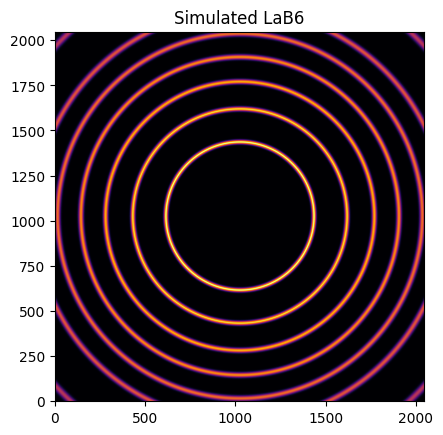

In [6]:
img = LaB6.fake_calibration_image(ai)
jupyter.display(img, label="Simulated LaB6")
pass

This image can be integrated in q-space and plotted:

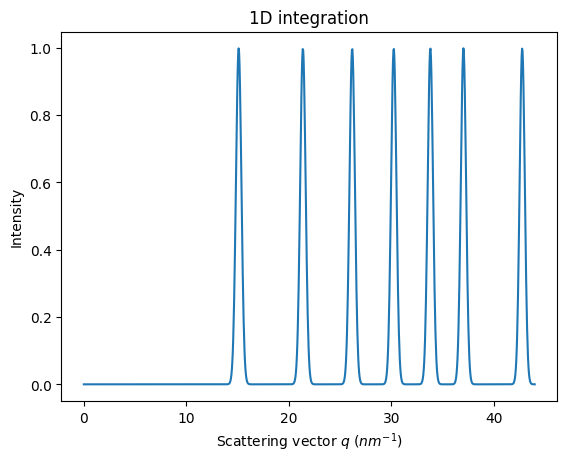

In [7]:
jupyter.plot1d(ai.integrate1d(img, 1000, method=method))
pass

Note pyFAI does now about the ring position but nothing about relative intensities of rings.

## Translation of the detector along the vertical axis

The vertical axis is defined along the *poni1*. If one moves the detector higher, the poni will appear at lower coordinates.
So lets define 5 upwards verical translations of half the detector size. 

For this we will duplicate 5x the AzimuthalIntegrator object, but instances of *AzimuthalIntegrator* are mutable, so it is important to create an actual *copy* and not an *view* on them. In Python, one can use the *copy* function of the *copy* module:

In [8]:
import copy

We will now offset the *poni1* value of each AzimuthalIntegratoe which correspond to a vertical translation. Each subsequent image is offsetted by half a detector width (stored as *poni1*).


Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= 0.000000e+00, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=0.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Wavelength= 1.000000e-10 m
SampleDetDist= 1.000000e-01 m	PONI= -6.144000e-02, 6.143988e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=1023.998, y=-1024.000 pix	Tilt= 0.000° tiltPlanRotation= 0.000° 𝛌= 1.000Å
Detector Titan 2k x 2k	 PixelSize= 6.000e-05, 6.000e-05 m
Wavelength= 1.00000

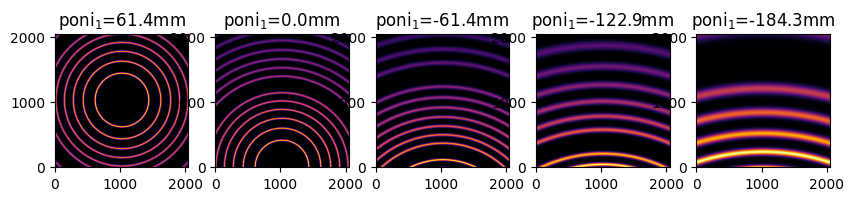

In [9]:
ais = []
imgs = []
fig, ax = subplots(1,5, figsize=(10,2))
for i in range(5):
    my_ai = copy.deepcopy(ai)
    my_ai.poni1 -= i*poni1
    my_img = LaB6.fake_calibration_image(my_ai)
    jupyter.display(my_img, label="poni$_1$=%3.1fmm"%(1e3*my_ai.poni1), ax=ax[i])
    ais.append(my_ai)
    imgs.append(my_img)
    print(my_ai)
    

## MultiGeometry integrator ##

The *MultiGeometry* instance can be created from any list of *AzimuthalIntegrator* instances or list of *poni-files*. Here we will use the former method.

The main difference of a *MultiIntegrator* with a "normal" *AzimuthalIntegrator* comes from the definition of the output space in the constructor of the object. One needs to specify the unit and the integration range. 

In [10]:
from pyFAI.multi_geometry import MultiGeometry

In [11]:
mg = MultiGeometry(ais, unit="q_A^-1", radial_range=(0, 8))
print(mg)

MultiGeometry integrator with 5 geometries on (0, 8) radial range (q_A^-1) and (-180, 180) azimuthal range (deg)


*MultiGeometry* integrators can be used in a similar way to "normal" *AzimuthalIntegrator*s. Keep in mind the output intensity is always scaled to absolute solid angle.

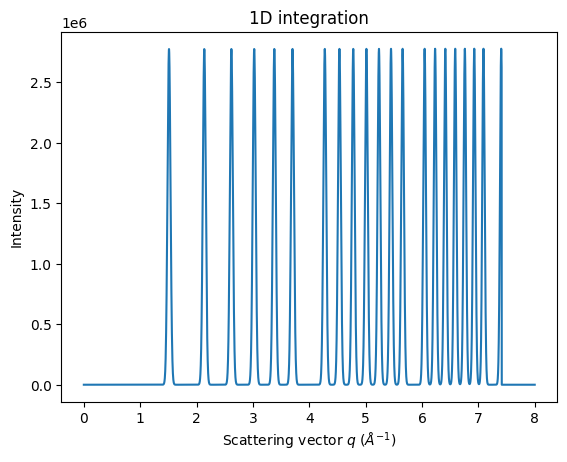

In [12]:
ax = jupyter.plot1d(mg.integrate1d(imgs, 10000, method=method))
pass

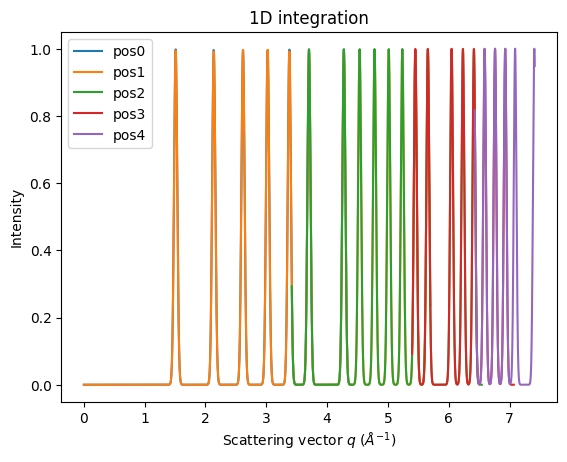

In [13]:
fig, ax = subplots()
for idx, (i, a)  in enumerate(zip(imgs, ais)):
    jupyter.plot1d(a.integrate1d(i, 1000, unit="q_A^-1", method=method), label="pos%i"%idx, ax=ax)

## Rotation of the detector 

The strength of translating the detector is that it simulates a larger detector, but this approach reaches its limit quikly as the higher the detector gets, the smallest the solid angle gets and induces artificial noise. One solution is to keep the detector at the same distance and rotate the detector.

This setup is common when mounting a detector on a goniometer.

### Creation of diffraction images

In this example we will use a Pilatus 200k with 2 modules. It has a gap in the middle of the two detectors and we will see how the *MultiGeometry* can help.

As previously, we will use LaB6 but instead of translating the images, we will rotate them along the second axis:

In [14]:
det = pyFAI.detectors.detector_factory("pilatus200k")
p1, p2, p3 = det.calc_cartesian_positions()
print(p3)
poni1 = p1.mean()
poni2 = p2.mean()
print(poni1)
print(poni2)

None
0.035002
0.04188201


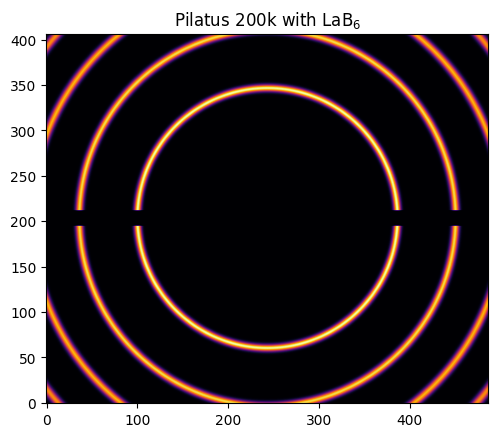

In [15]:
ai = AzimuthalIntegrator(dist=0.1, poni1=poni1, poni2=poni2, detector=det)
img = LaB6.fake_calibration_image(ai)

jupyter.display(img, label="Pilatus 200k with LaB$_6$")
pass

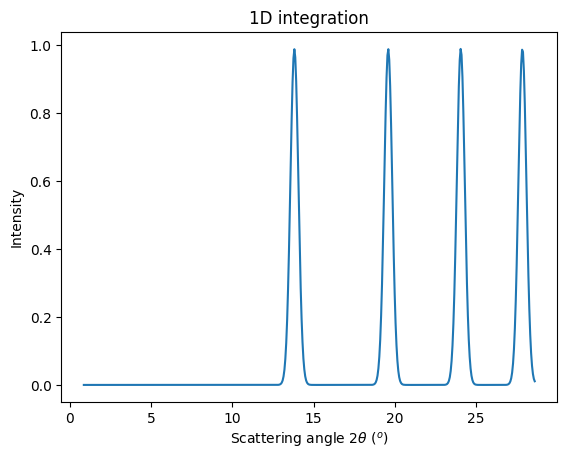

In [16]:
jupyter.plot1d(ai.integrate1d(img, 500, unit="2th_deg", method=method))
pass

We will rotate the detector with a step size of 15 degrees

Detector Pilatus 200k	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=0.000000  rot3=0.000000 rad
DirectBeamDist= 100.000 mm	Center: x=243.500, y=203.500 pix	Tilt= 0.000° tiltPlanRotation= 0.000°
Detector Pilatus 200k	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=-0.261799  rot3=0.000000 rad
DirectBeamDist= 103.528 mm	Center: x=243.500, y=47.716 pix	Tilt= 15.000° tiltPlanRotation= -90.000°
Detector Pilatus 200k	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=-0.523599  rot3=0.000000 rad
DirectBeamDist= 115.470 mm	Center: x=243.500, y=-132.169 pix	Tilt= 30.000° tiltPlanRotation= -90.000°
Detector Pilatus 200k	 PixelSize= 1.720e-04, 1.720e-04 m
SampleDetDist= 1.000000e-01 m	PONI= 3.500200e-02, 4.188201e-02 m	rot1=0.000000  rot2=-0.785398  rot3=0.000000 rad
DirectBeamDist= 1

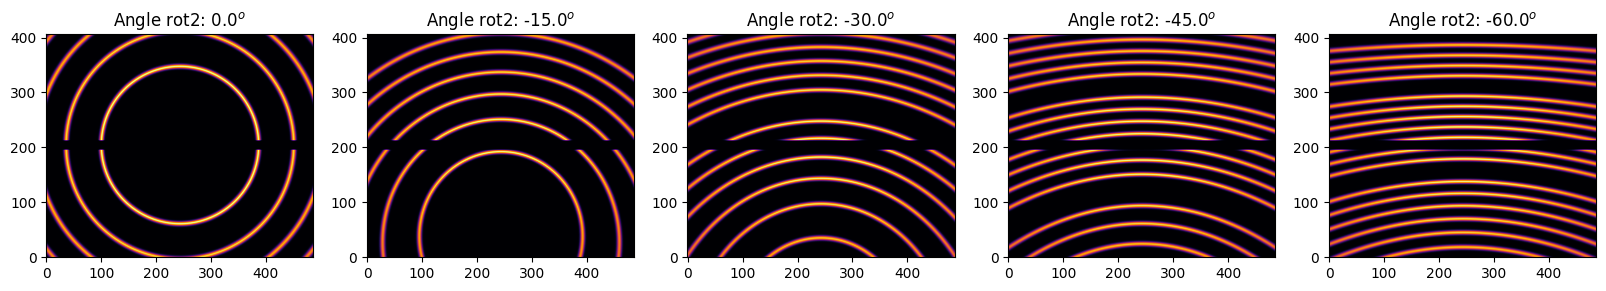

In [17]:
step = 15*numpy.pi/180
ais = []
imgs = []
fig, ax = subplots(1, 5, figsize=(20,4))
for i in range(5):
    my_ai = copy.deepcopy(ai)
    my_ai.rot2 -= i*step
    my_img = LaB6.fake_calibration_image(my_ai)
    jupyter.display(my_img, label="Angle rot2: %.1f$^o$"%numpy.degrees(my_ai.rot2), ax=ax[i])
    ais.append(my_ai)
    imgs.append(my_img)
    print(my_ai)


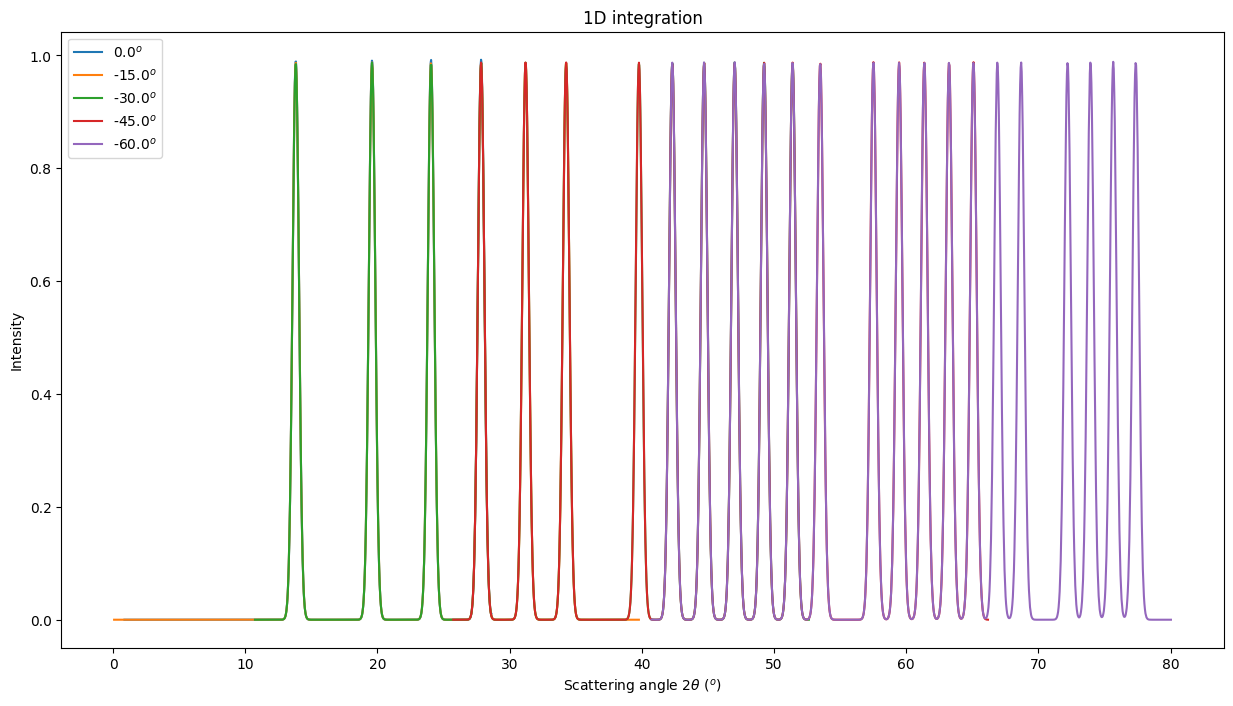

In [18]:
fig, ax = subplots(figsize=(15,8))
for i, a in zip(imgs, ais):
    jupyter.plot1d(a.integrate1d(i, 1000, unit="2th_deg", method=method), 
                   label="%.1f$^o$"%numpy.degrees(a.rot2), ax=ax)
pass

### Creation of the MultiGeometry

This time we will work in 2theta angle using degrees:

MultiGeometry integrator with 5 geometries on (0, 90) radial range (2th_deg) and (-180, 180) azimuthal range (deg)


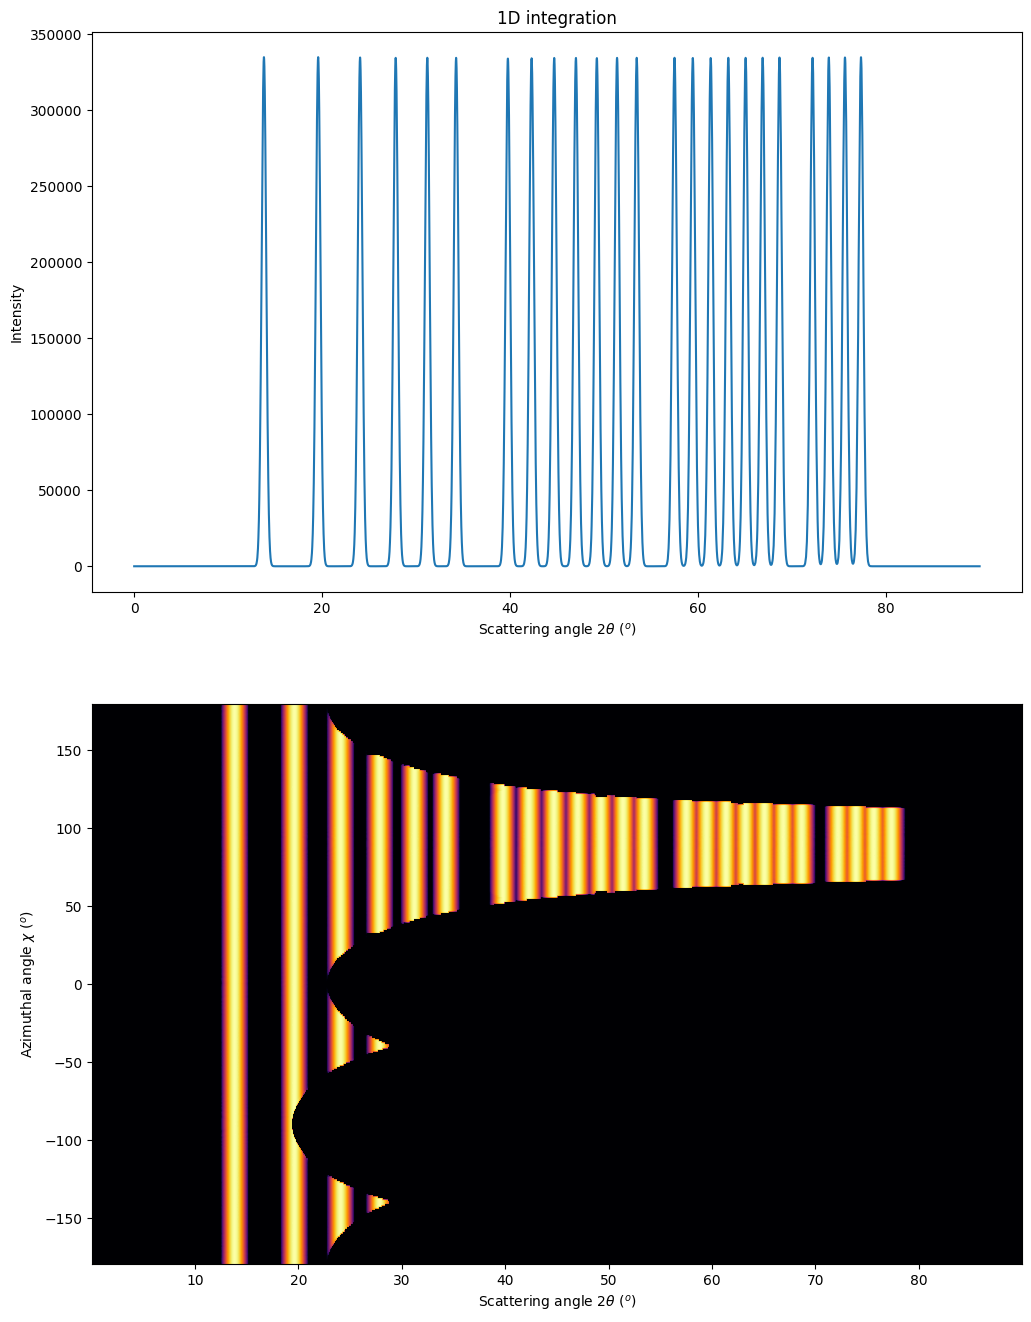

In [19]:
mg = MultiGeometry(ais, unit="2th_deg", radial_range=(0, 90))
print(mg)
fig, ax = subplots(2, 1, figsize=(12,16))
jupyter.plot1d(mg.integrate1d(imgs, 10000, method=method), 
               ax=ax[0])
res2d = mg.integrate2d(imgs, 1000,360)
jupyter.plot2d(res2d, ax=ax[1])
pass

## How to fill-up gaps in arrays of pixel detectors during 2D integration

We will use ImXpad detectors which exhibits large gaps.


In [20]:
det = pyFAI.detectors.detector_factory("Xpad_flat")
p1, p2, p3 = det.calc_cartesian_positions()
print(p3)
poni1 = p1.mean()
poni2 = p2.mean()
print(poni1)
print(poni2)

None
0.074894994
0.03757


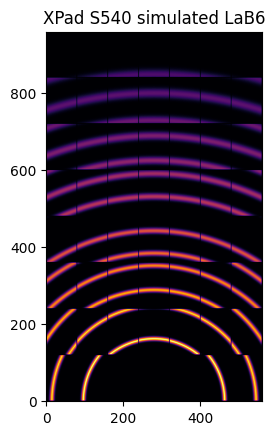

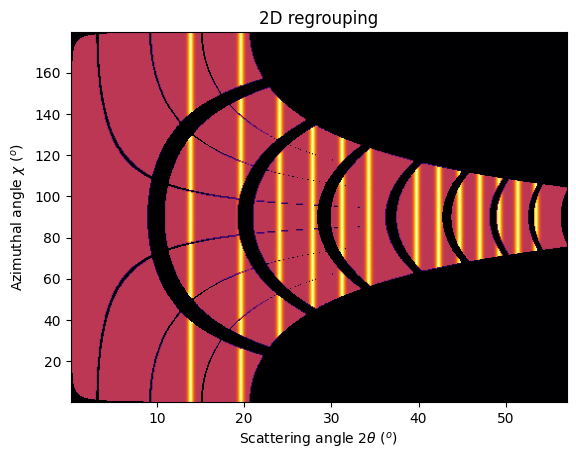

In [21]:
ai = AzimuthalIntegrator(dist=0.1, poni1=0, poni2=poni2, detector=det)
img = LaB6.fake_calibration_image(ai)
jupyter.display(img, label="XPad S540 simulated LaB6")
jupyter.plot2d(ai.integrate2d_ng(img, 500, 360, azimuth_range=(0,180), unit="2th_deg", dummy=-1, method=method2d), 
               label="2D")
pass

To observe textures, it is mandatory to fill the large empty space. This can be done by tilting the detector by a few degrees to higher 2theta angle (yaw 2x5deg) and turn the detector along the azimuthal angle (roll 2x5deg):

MultiGeometry integrator with 9 geometries on (0, 60) radial range (2th_deg) and (0, 180) azimuthal range (deg)


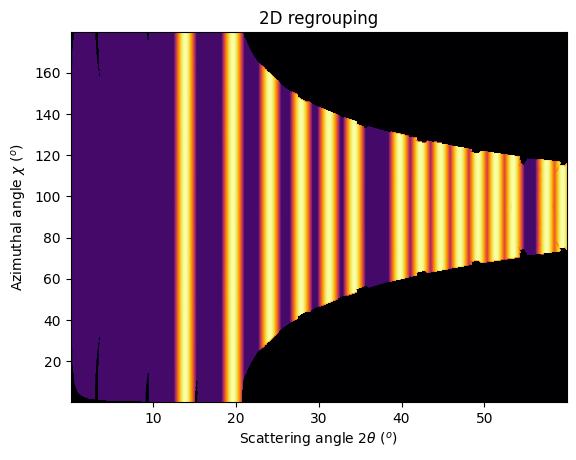

In [22]:
step = 5*numpy.pi/180
nb_geom = 3
ais = []
imgs = []
for i in range(nb_geom):
    for j in range(nb_geom):
        my_ai = copy.deepcopy(ai)
        my_ai.rot2 -= i*step
        my_ai.rot3 -= j*step
        my_img = LaB6.fake_calibration_image(my_ai)
        ais.append(my_ai)
        imgs.append(my_img)
mg = MultiGeometry(ais, unit="2th_deg", radial_range=(0, 60), azimuth_range=(0, 180), empty=-5)
print(mg)
res2d = mg.integrate2d(imgs, 1000, 360, method=method2d)
jupyter.plot2d(res2d, label="Filled")
pass

As on can see, the gaps have disapeared and the statistics is much better, except on the border were only one image contributes to the integrated image.

## Conclusion

The multi_geometry module of pyFAI makes powder diffraction experiments with small moving detectors much easier.

Some people would like to stitch input images together prior to integration. There are plenty of good tools to do this: generalist one like 
[Photoshop](http://www.adobe.com/fr/products/photoshop.html) or more specialized ones like [AutoPano](http://www.kolor.com/autopano). More seriously this can be using the distortion module of a detector to re-sample the signal on a regular grid but one will have to store on one side the number of actual pixel contributing to a regular pixels and on the other the total intensity contained in the regularized pixel. Without the former information, doing science with a rebinned image is as meaningful as using Photoshop.


In [23]:
print(f"Excution time: %.3f"%(time.perf_counter()-start_time))

Excution time: 42.863
